# Trains CGAN on MNIST using Keras
* Source : https://github.com/wikibook/keras


CGAN is Conditional Generative Adversarial Nets.
This version of CGAN is similar to DCGAN. The difference mainly
is that the z-vector of geneerator is conditioned by a one-hot label
to produce specific fake images. The discriminator is trained to
discriminate real from fake images that are conditioned on
specific one-hot labels.

[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

[2] Mirza, Mehdi, and Simon Osindero. "Conditional generative
adversarial nets." arXiv preprint arXiv:1411.1784 (2014).



In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse



# Build a Generator Model

    Inputs are concatenated before Dense layer.
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.

## Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)

## Returns
        Model: Generator Model


In [2]:

def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    return generator



#Build a Discriminator Model

    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.

## Arguments
        inputs (Layer): Input layer of the discriminator (the image)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)

## Returns
        Model: Discriminator Model


In [3]:
def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator



# Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images.
    Adversarial is trained next with fake images pretending to be real.
    Discriminator inputs are conditioned by train labels for real images,
    and random labels for fake images.
    Adversarial inputs are conditioned by random labels.
    Generate sample images per save_interval.

# Arguments
        models (list): Generator, Discriminator, Adversarial models
        data (list): x_train, y_train data
        params (list): Network parameters

In [4]:
def train(models, data, params):
    # the GAN models
    generator, discriminator, adversarial = models
    # images and labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    # number of elements in train dataset
    train_size = x_train.shape[0]

    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]

        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images conditioned on fake 1-hot labels w/ label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution        
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                           batch_size)]
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
    
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")



# Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

## Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

In [5]:
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')



# Test Generator

In [6]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label
    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")



# Build and train models


In [7]:

def build_and_train_models():
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim

    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)


# Training and Test


11490434/11490434 [==============================] - 2s 0us/step
Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 class_labels (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 784)          8624        ['class_labels[0][0]']           
                                                                                                  
 discriminator_input (InputLaye  [(None, 28, 28, 1)]  0          []                               
 r)                                                                                               
                                                                                                  
 reshape (Reshape)   

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 10ms/step
7505: [discriminator loss: 0.715366, acc: 0.523438] [adversarial loss: 0.752320, acc: 0.484375]
2/2 [==============================] - 0s 7ms/step
7506: [discriminator loss: 0.650831, acc: 0.593750] [adversarial loss: 0.982901, acc: 0.156250]
2/2 [==============================] - 0s 12ms/step
7507: [discriminator loss: 0.657957, acc: 0.625000] [adversarial loss: 0.705613, acc: 0.500000]
2/2 [==============================] - 0s 8ms/step
7508: [discriminator loss: 0.630242, acc: 0.609375] [adversarial loss: 0.862336, acc: 0.265625]
2/2 [==============================] - 0s 7ms/step
7509: [discriminator loss: 0.670540, acc: 0.585938] [adversarial loss: 0.865166, acc: 0.250000]
2/2 [==============================] - 0s 12ms/step
7510: [discriminator loss: 0.646146, acc: 0.617188] [adversarial loss: 0.818270, acc: 0.390625]
2/2 [==============================] - 0s 7ms/step
7511: [discri

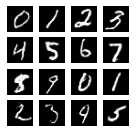

In [8]:
latent_size = 100
batch_size = 64
train_steps = 10000
lr = 0.0004
build_and_train_models()


1/1 [==============================] - 0s 139ms/step
test_outputs  labels for generated images:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


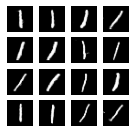

In [9]:
generator = load_model("cgan_mnist.h5")
test_generator(generator,1)

1/1 [==============================] - 0s 20ms/step
test_outputs  labels for generated images:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


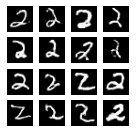

In [10]:
test_generator(generator,2)

1/1 [==============================] - 0s 15ms/step
test_outputs  labels for generated images:  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


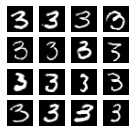

In [11]:
test_generator(generator,3)

1/1 [==============================] - 0s 24ms/step
test_outputs  labels for generated images:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


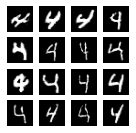

In [12]:
test_generator(generator,4)

1/1 [==============================] - 0s 15ms/step
test_outputs  labels for generated images:  [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


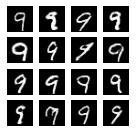

In [14]:
test_generator(generator,9)